In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import numpy as np
import cv2
import time
import sys
import re
from copy import deepcopy
from collections import defaultdict
from itertools import islice
from tqdm import tqdm_notebook
from time import time
from easydict import EasyDict
from IPython.core.debugger import set_trace
from matplotlib import pyplot as plt
from warnings import filterwarnings

import torch
from torch import nn
import torch.nn.functional as F
from torch import autograd
from torch.utils.data import DataLoader


from mvn.utils.img import image_batch_to_numpy, denormalize_image,to_numpy
from mvn.models.triangulation import VolumetricTriangulationNet
from mvn.models.pose_hrnet import get_pose_net as get_pose_hrnet
from mvn.models.pose_resnet import get_pose_net as get_pose_resnet

from mvn.utils.multiview import project_3d_points_to_image_plane_without_distortion
from mvn.utils.vis import draw_2d_pose
from mvn.utils import img
from mvn.utils import multiview
from mvn.utils import volumetric
from mvn.utils import op
from mvn.utils import vis
from mvn.utils import misc
from mvn.utils import cfg
from mvn.datasets import utils as dataset_utils
from mvn.datasets.human36m import Human36MMultiViewDataset, Human36MTemporalDataset

from train import setup_human36m_dataloaders

from mvn.models.volumetric_adain import VolumetricTemporalAdaINNet
from mvn.models.volumetric_grid import VolumetricTemporalGridDeformation

from IPython.core.debugger import set_trace

%matplotlib inline

retval = {
    'subject_names': ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11'],
    'camera_names': ['54138969', '55011271', '58860488', '60457274'],
    'action_names': [
        'Directions-1', 'Directions-2',
        'Discussion-1', 'Discussion-2',
        'Eating-1', 'Eating-2',
        'Greeting-1', 'Greeting-2',
        'Phoning-1', 'Phoning-2',
        'Posing-1', 'Posing-2',
        'Purchases-1', 'Purchases-2',
        'Sitting-1', 'Sitting-2',
        'SittingDown-1', 'SittingDown-2',
        'Smoking-1', 'Smoking-2',
        'TakingPhoto-1', 'TakingPhoto-2',
        'Waiting-1', 'Waiting-2',
        'Walking-1', 'Walking-2',
        'WalkingDog-1', 'WalkingDog-2',
        'WalkingTogether-1', 'WalkingTogether-2']
}

JOINT_H36_DICT = {0:'RFoot',
                 1:'RKnee',
                 2:'RHip',
                 3:'LHip',
                 4:'LKnee',
                 5:'LFoot',
                 6:'Hip',
                 7:'Spine',
                 8:'Thorax',
                 9:'Head',
                 10:'RWrist',
                 11:'RElbow',
                 12:'RShoulder',
                 13:'LShoulder',
                 14:'LElbow',
                 15:'LWrist',
                 16:'Neck/Nose'}

JOINT_NAMES_DICT = {
                    0: "nose",
                    1: "left_eye",
                    2: "right_eye",
                    3: "left_ear",
                    4: "right_ear",
                    5: "left_shoulder",
                    6: "right_shoulder",
                    7: "left_elbow",
                    8: "right_elbow",
                    9: "left_wrist",
                    10: "right_wrist",
                    11: "left_hip",
                    12: "right_hip",
                    13: "left_knee",
                    14: "right_knee",
                    15: "left_ankle",
                    16: "right_ankle"
                }


CONNECTIVITY_DICT = {
    'cmu': [(0, 2), (0, 9), (1, 0), (1, 17), (2, 12), (3, 0), (4, 3), (5, 4), (6, 2), (7, 6), (8, 7), (9, 10), (10, 11), (12, 13), (13, 14), (15, 1), (16, 15), (17, 18)],
    'coco': [(0, 1), (0, 2), (1, 3), (2, 4), (5, 7), (7, 9), (6, 8), (8, 10), (11, 13), (13, 15), (12, 14), (14, 16), (5, 6), (5, 11), (6, 12), (11, 12)],
    "mpii": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 9), (8, 12), (8, 13), (10, 11), (11, 12), (13, 14), (14, 15)],
    "human36m": [(0, 1), (1, 2), (2, 6), (5, 4), (4, 3), (3, 6), (6, 7), (7, 8), (8, 16), (9, 16), (8, 12), (11, 12), (10, 11), (8, 13), (13, 14), (14, 15)],
    "kth": [(0, 1), (1, 2), (5, 4), (4, 3), (6, 7), (7, 8), (11, 10), (10, 9), (2, 3), (3, 9), (2, 8), (9, 12), (8, 12), (12, 13)],
}

device = 'cuda:0' #torch.cuda.current_device()

OFFSET = 12

# torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.enabled = True 

In [4]:
experiment_type = 'resnet_50/adain_1d'
experiment_name = 'h36_sv32_dist_adain-all-gn_s2v-lstm-1024-1024-1024-gn_vf32_f2v-backbone-C4-1024-group_resnet50-gn-nostylegrad_dt-12_dil-3-1-1_lr-1e-4@12.03.2020-19:00:21'     

# experiment_type = 'resnet_50/baseline'
# experiment_name = 'h36_sv32_dist_resnet50-gn_v2v-v1-gn-no-aggr_1-1_lr-1e-4_boneloss-1e-4@19.03.2020-19:21:45'

experiment_root = os.path.join('../logs/', experiment_type, experiment_name)
config_path = experiment_root + '/config.yaml'

config = cfg.load_config(config_path)
config.dataset.val.retain_every_n_frames_in_test = 1

_, val_loader, _ = setup_human36m_dataloaders(config,
                                             is_train=False,
                                             distributed_train=False)

batch_size, dt, dilation = val_loader.batch_size, val_loader.dataset.dt, val_loader.dataset.dilation

pivot_type = config.dataset.pivot_type 
keypoints_per_frame = config.dataset.val.keypoints_per_frame if hasattr(config.dataset.val, 'keypoints_per_frame') else False
pivot_position = {'first':-1, 'intermediate':dt//2}[pivot_type]

if not hasattr(config.model.backbone, 'group_norm'):
    config.model.backbone.group_norm = False

print('Batch size:', batch_size, '\n',\
      'dt:', dt, '\n',\
      'dilation:', dilation, '\n',\
      'pivot_type:', pivot_type, '\n',\
      'pivot_position:', pivot_position,'\n',\
      'keypoints_per_frame', keypoints_per_frame)


Batch size: 1 
 dt: 12 
 dilation: 3 
 pivot_type: first 
 pivot_position: -1 
 keypoints_per_frame False


# Check dataset output

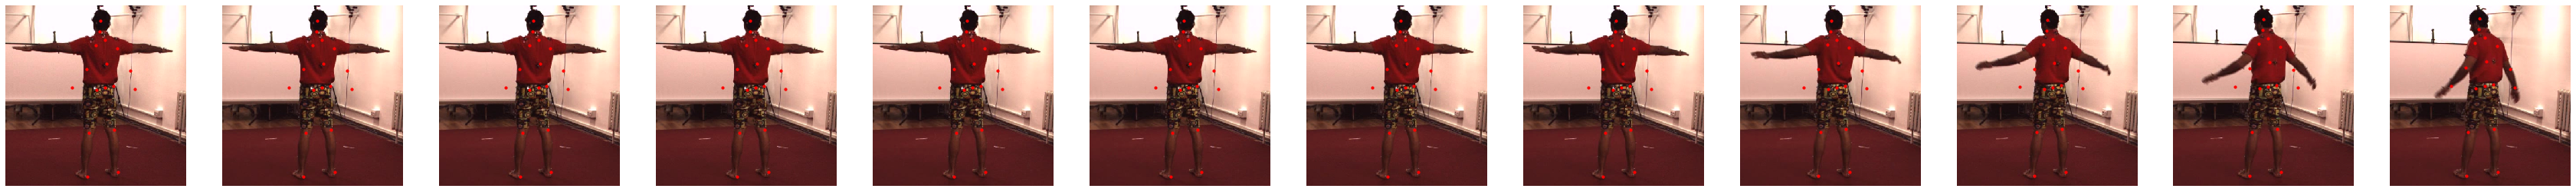

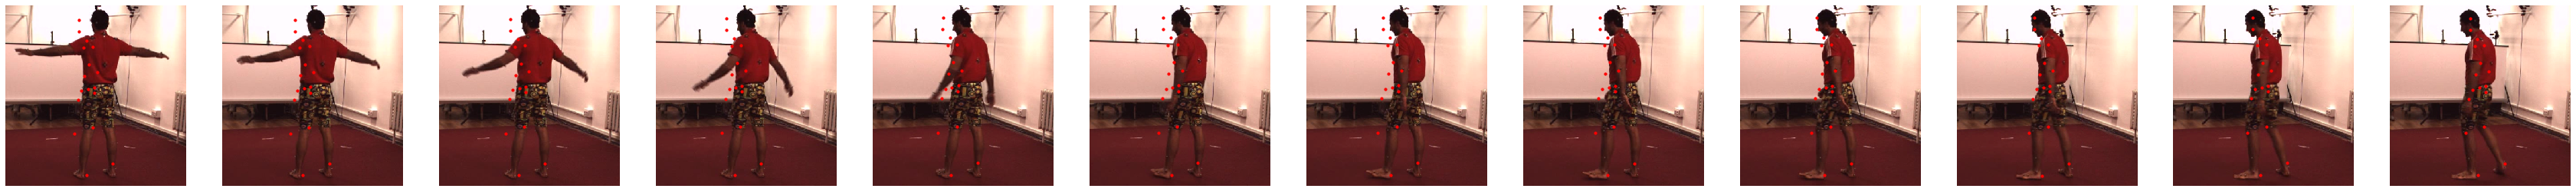

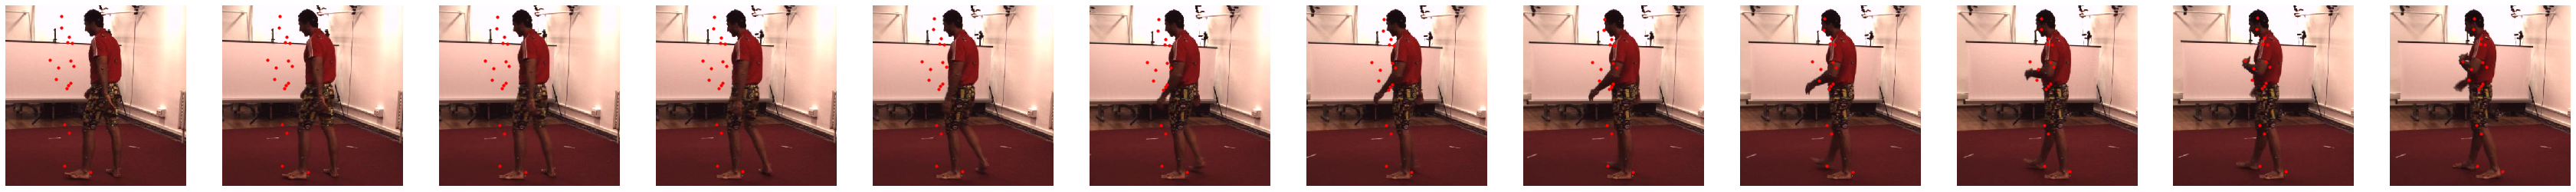

In [4]:
for batch in islice(val_loader, 3):

    n_views = batch['images'].shape[1]
    batch_size = batch['images'].shape[0]
    
    fig, axes = plt.subplots(ncols=n_views, nrows=1, figsize=(5 * n_views, 5))
    for i in range(n_views):
        # first row
        detection = batch['detections'][0][i]
        *bbox, c = detection
        
        image = batch['images'][0][i]
        image = denormalize_image(image).astype(np.uint8)
        image = image[..., ::-1]  # bgr -> rgb
        camera_name = batch['cameras'][i][0].name
        title = "{}, detection conf: {:.3}".format(camera_name, c)
        
        # second row
        keypoints_3d = batch['keypoints_3d'][0][:, :3]
        proj_matrix = batch['cameras'][i][0].projection
#         image_shape_before_resize = batch['image_shapes_before_resize'][0][i]
        image_shape = image.shape[:2]

        keypoints_2d_wrt_new = multiview.project_3d_points_to_image_plane_without_distortion(proj_matrix, keypoints_3d)
#         keypoints_2d_wrt_orig = transform_points_after_crop_and_resize(keypoints_2d_wrt_new, (bbox[0], bbox[1]), image_shape_before_resize, image_shape, forward=True)
        
        axes[i].set_xlim(0, image.shape[1])
        axes[i].set_ylim(0, image.shape[0])
        axes[i].invert_yaxis()
        axes[i].imshow(image)
        axes[i].scatter(keypoints_2d_wrt_new[:, 0], keypoints_2d_wrt_new[:, 1], s=10, c='red')
        
        axes[i].axis('off')
    plt.show()

# Model

In [5]:
# config.model.cuboid_multiplier = 1.0
# config.model.rotation = False
# config.model.transfer_cmu_to_human36m = False
# config.model.encoder_normalization_type = 'group_norm'
# config.model.upscale_bottleneck = False
# config.model.f2v_intermediate_channels = config.model.intermediate_channels    
# config.model.f2v_normalization_type = 'group_norm'   
# config.model.v2v_type = 'v1'
# config.model.spade_broadcasting_type = 'unprojecting'
    
model = {
    "vol": VolumetricTriangulationNet,
    "vol_temporal_adain":VolumetricTemporalAdaINNet
}[config.model.name](config, device=device).to(device)

print ('Loaded {} model'.format(config.model.name))

Loading pretrained weights from: ./data/pose_resnet_4.5_pixels_human36m.pth
Successfully loaded pretrained weights for backbone
Only resnet50 backbone is used...
backbone:  34.0M params
features_sequence_to_vector:  8.4M params
encoder:  11.06M params
volume_net:  21.05M params
process_features:  0.01M params
Loaded vol_temporal_adain model


In [6]:
checkpoints_path = experiment_root + '/checkpoints/'
weights_path = checkpoints_path + '/weights.pth'
model.load_state_dict(torch.load(weights_path)['model_state'], strict=True)
print ('Done')

Done


# Check model output

In [7]:
# for batch in train_loader:
#     images_batch, keypoints_3d_gt, keypoints_3d_validity_gt, proj_matricies_batch = dataset_utils.prepare_batch(batch, device)
#     break

# (keypoints_3d_pred, 
# features_pred, 
# volumes_pred, 
# confidences_pred, 
# cuboids_pred, 
# coord_volumes_pred, 
# base_points_pred) = model(images_batch, batch)    

# Helper functions


In [8]:
def get_start_stop_frame_indxs(labels):
    
    frame_idx = labels['table']['frame_idx']
    change_mask = np.concatenate((frame_idx[:-1] > frame_idx[1:], [True]))
    stop_frame_indxs = frame_idx[change_mask]
    
    videos_lengths = stop_frame_indxs+1
    stop_indexes = np.cumsum(videos_lengths) - 1
    
    start_indexes = np.array([0] + list(stop_indexes + 1)[:-1])
    
    return start_indexes, stop_indexes

def index_to_name(i_stop, stop_indexes, val=True):
    sublects = ['S9', 'S11']
    actions = retval['action_names']
    
    number = np.arange(len(stop_indexes))[i_stop <= stop_indexes][0]
    subject_number = number//len(actions)
    action_number = number % len(actions)
    return sublects[subject_number], actions[action_number]

def get_error_diffs(keypoints_gt, keypoints_pred):
    
    rmse = lambda x,y: np.sqrt((x-y)**2).mean()
    assert len(keypoints_gt) == len(keypoints_pred) 
    n_frames = len(keypoints_gt)
    
    gt_diffs, pred_diffs = [], []
    
    for i in range(1,n_frames):

        if KIND == "mpii":
            root_index = 6 
        else:
            raise RuntimeError()

        keypoints_gt_relative = keypoints_gt - keypoints_gt[:, root_index:root_index + 1, :]
        keypoints_pred_relative = keypoints_pred - keypoints_pred[:, root_index:root_index + 1, :]

        per_pose_error_relative = np.sqrt(((keypoints_gt_relative - keypoints_pred_relative) ** 2).sum(2)).mean(1)
        
        gt_diffs.append(rmse(keypoints_gt[i], keypoints_gt[i-1]))
        pred_diffs.append(rmse(keypoints_pred, keypoints_pred[i-1]))

    pred_diffs = np.array(pred_diffs)
    gt_diffs = np.array(gt_diffs)
    
    return per_pose_error_relative, gt_diffs, pred_diffs

In [9]:
labels=val_loader.dataset.labels
start_frame_indexes, stop_frame_indxs=get_start_stop_frame_indxs(labels)

### define ###
length=100
action = 'Directions-1'
subject = 'S9'
camera_index = 0
##############

action_index=retval['action_names'].index(action)
offset = len(retval['action_names']) if subject == 'S11' else 0
start=start_frame_indexes[offset:][action_index].item()

assert length%batch_size==0
assert subject in ['S9', 'S11']
assert subject, action == index_to_name(start+length, stop_frame_indxs)

# Collect keypoints from multiview

In [10]:
def normalize_temporal_images_batch(images_batch, pivot_position):
    images_batch = images_batch[:,pivot_position]
    # normalize images batch
    images_batch = image_batch_to_numpy(images_batch.detach().cpu())
    images_batch = denormalize_image(images_batch).astype(np.uint8)
    images_batch = images_batch[..., ::-1]  # bgr -> rgb
    return images_batch

In [10]:
USE_RANDOM_STYLE_VECTOR = False
RETURN_STYLE_VECTOR = True

KIND = model.kind
series = defaultdict(list)
if RETURN_STYLE_VECTOR:
    series['style_vectors'] = defaultdict(list)
series['images'] = defaultdict(list)
series['proj_matrices'] = defaultdict(list)
eval_view = 0 # supported [0,1,2,3] cameras
collate_fn = dataset_utils.make_collate_fn(randomize_n_views=False,
                                           min_n_views=None,
                                           max_n_views=None)

model.eval()
with torch.no_grad():
    for i in tqdm_notebook(range(start,start+length)):
        ##############
        # EVALUATION #
        ##############
        batch = val_loader.dataset.__getitem__(i + eval_view*val_loader.dataset.n_sequences)
        if batch is None:
            'Batch is none...'
            break
        
        batch = collate_fn([batch])
        (images_batch, 
        keypoints_3d_gt, 
        keypoints_3d_validity_batch_gt, 
        proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
        
        if RETURN_STYLE_VECTOR:
             output = model(images_batch, batch, return_style_vector=True)
        else:    
            output = model(images_batch, batch)
        torch.cuda.empty_cache()
        
        if USE_RANDOM_STYLE_VECTOR:
            randomized_output = model(images_batch, batch, randomize_style=True)
            keypoints_3d_pred_random_style = randomized_output[0]
            keypoints_random_style = keypoints_3d_pred_random_style.detach().cpu().numpy()
            series['keypoints_random_style'].append(keypoints_random_style)
            torch.cuda.empty_cache()

        keypoints_3d_pred = output[0]
        batch_size, n_views, n_joints = keypoints_3d_gt.shape[:3]

        # normalize all stuff
        proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
        images_batch = normalize_temporal_images_batch(images_batch, pivot_position)
        keypoints = keypoints_3d_pred.detach().cpu().numpy()
        keypoints_gt =  keypoints_3d_gt.detach().cpu().numpy()
        
        series['keypoints'].append(keypoints)
        series['keypoints_gt'].append(keypoints_gt)
        
        series['images'][eval_view].append(images_batch)
        series['proj_matrices'][eval_view].append(proj_matricies_batch)
        
        ##############
        # PROJECTING #
        ##############
        for view_i in range(4):
            if view_i == eval_view:
                continue
            else:
                batch = val_loader.dataset.__getitem__(i + view_i*val_loader.dataset.n_sequences)
                batch = collate_fn([batch])
                
                (images_batch, 
                keypoints_3d_gt, 
                keypoints_3d_validity_batch_gt, 
                proj_matricies_batch) = dataset_utils.prepare_batch(batch, device)
                
                # normalize all stuff
                proj_matricies_batch = proj_matricies_batch[:,pivot_position].detach().cpu().numpy()
                images_batch = normalize_temporal_images_batch(images_batch, pivot_position)
                
                series['images'][view_i].append(images_batch)
                series['proj_matrices'][view_i].append(proj_matricies_batch)
        
series['keypoints'] = np.concatenate(series['keypoints'],0)
series['keypoints_gt'] = np.concatenate(series['keypoints_gt'],0)
if USE_RANDOM_STYLE_VECTOR:
    series['keypoints_random_style'] = np.concatenate(series['keypoints_random_style'],0)
if RETURN_STYLE_VECTOR:
    series['style_vectors'] = np.concatenate(series['style_vectors'],0) 
for i in range(4):
    series['images'][i] = np.concatenate(series['images'][i],0)
    series['proj_matrices'][i] = np.concatenate(series['proj_matrices'][i],0)

In [12]:
# np.save(f'./action-{action}_subj-{subject}_l{length}-eval-{eval_view}_model-{config.model.name}', series)

# Plot error

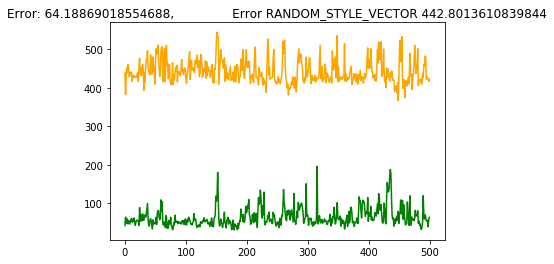

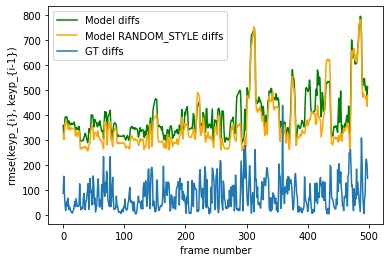

In [79]:
if USE_RANDOM_STYLE_VECTOR:
    error, gt_diffs, model_diffs = get_error_diffs(series['keypoints_gt'], series['keypoints'])
    error_rand_style, _, model_diffs_rand_style = get_error_diffs(series['keypoints_gt'], series['keypoints_random_style'])

    plt.figure()
    plt.plot(error, 'g', label='Error')
    plt.plot(error_rand_style, 'orange', label='Error')
    
    plt.title(f"Error: {error.mean()}, \
              Error RANDOM_STYLE_VECTOR {error_rand_style.mean()}" )
    plt.figure()
    plt.plot(model_diffs, 'g',label='Model diffs')
    plt.plot(model_diffs_rand_style, 'orange',label='Model RANDOM_STYLE diffs')
    plt.plot(gt_diffs, label='GT diffs')
    plt.xlabel('frame number')
    plt.ylabel('rmse(keyp_{i}, keyp_{i-1})')
    
    plt.legend()


# Post processing

In [17]:
# from scipy.signal import savgol_filter, savgol_coeffs
# n_joints = series['keypoints'].shape[1]
# series['keypoints_smoothed'] = []
# for i in range(n_joints):
#     joint_coord_sequence = series['keypoints'][:,i]
#     series['keypoints_smoothed'] += [savgol_filter(joint_coord_sequence, window_length=25, polyorder = 2, axis=0)]
# series['keypoints_smoothed'] = np.stack(series['keypoints_smoothed'], 1)

In [18]:
# coord=1
# joint = 3
# plt.plot(series['keypoints_smoothed'][:,joint,coord][:20],'r', label='smoothed')
# plt.plot(series['keypoints'][:,joint,coord][:20], label='original')
# plt.legend()

# Make Video

In [30]:
video_path = os.path.join('videos/',experiment_type, experiment_name)
if not os.path.isdir(video_path):
    os.makedirs(video_path)
    print ('video_path - Created')
else:
    print ('video_path - Already exists')
    
keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
if not os.path.isdir(keypoints_dir):
    os.makedirs(keypoints_dir)
    print ('keypoints_dir - Created')
else:
    print ('keypoints_dir - Already exists')        

video_path - Created
keypoints_dir - Created


# Generate images

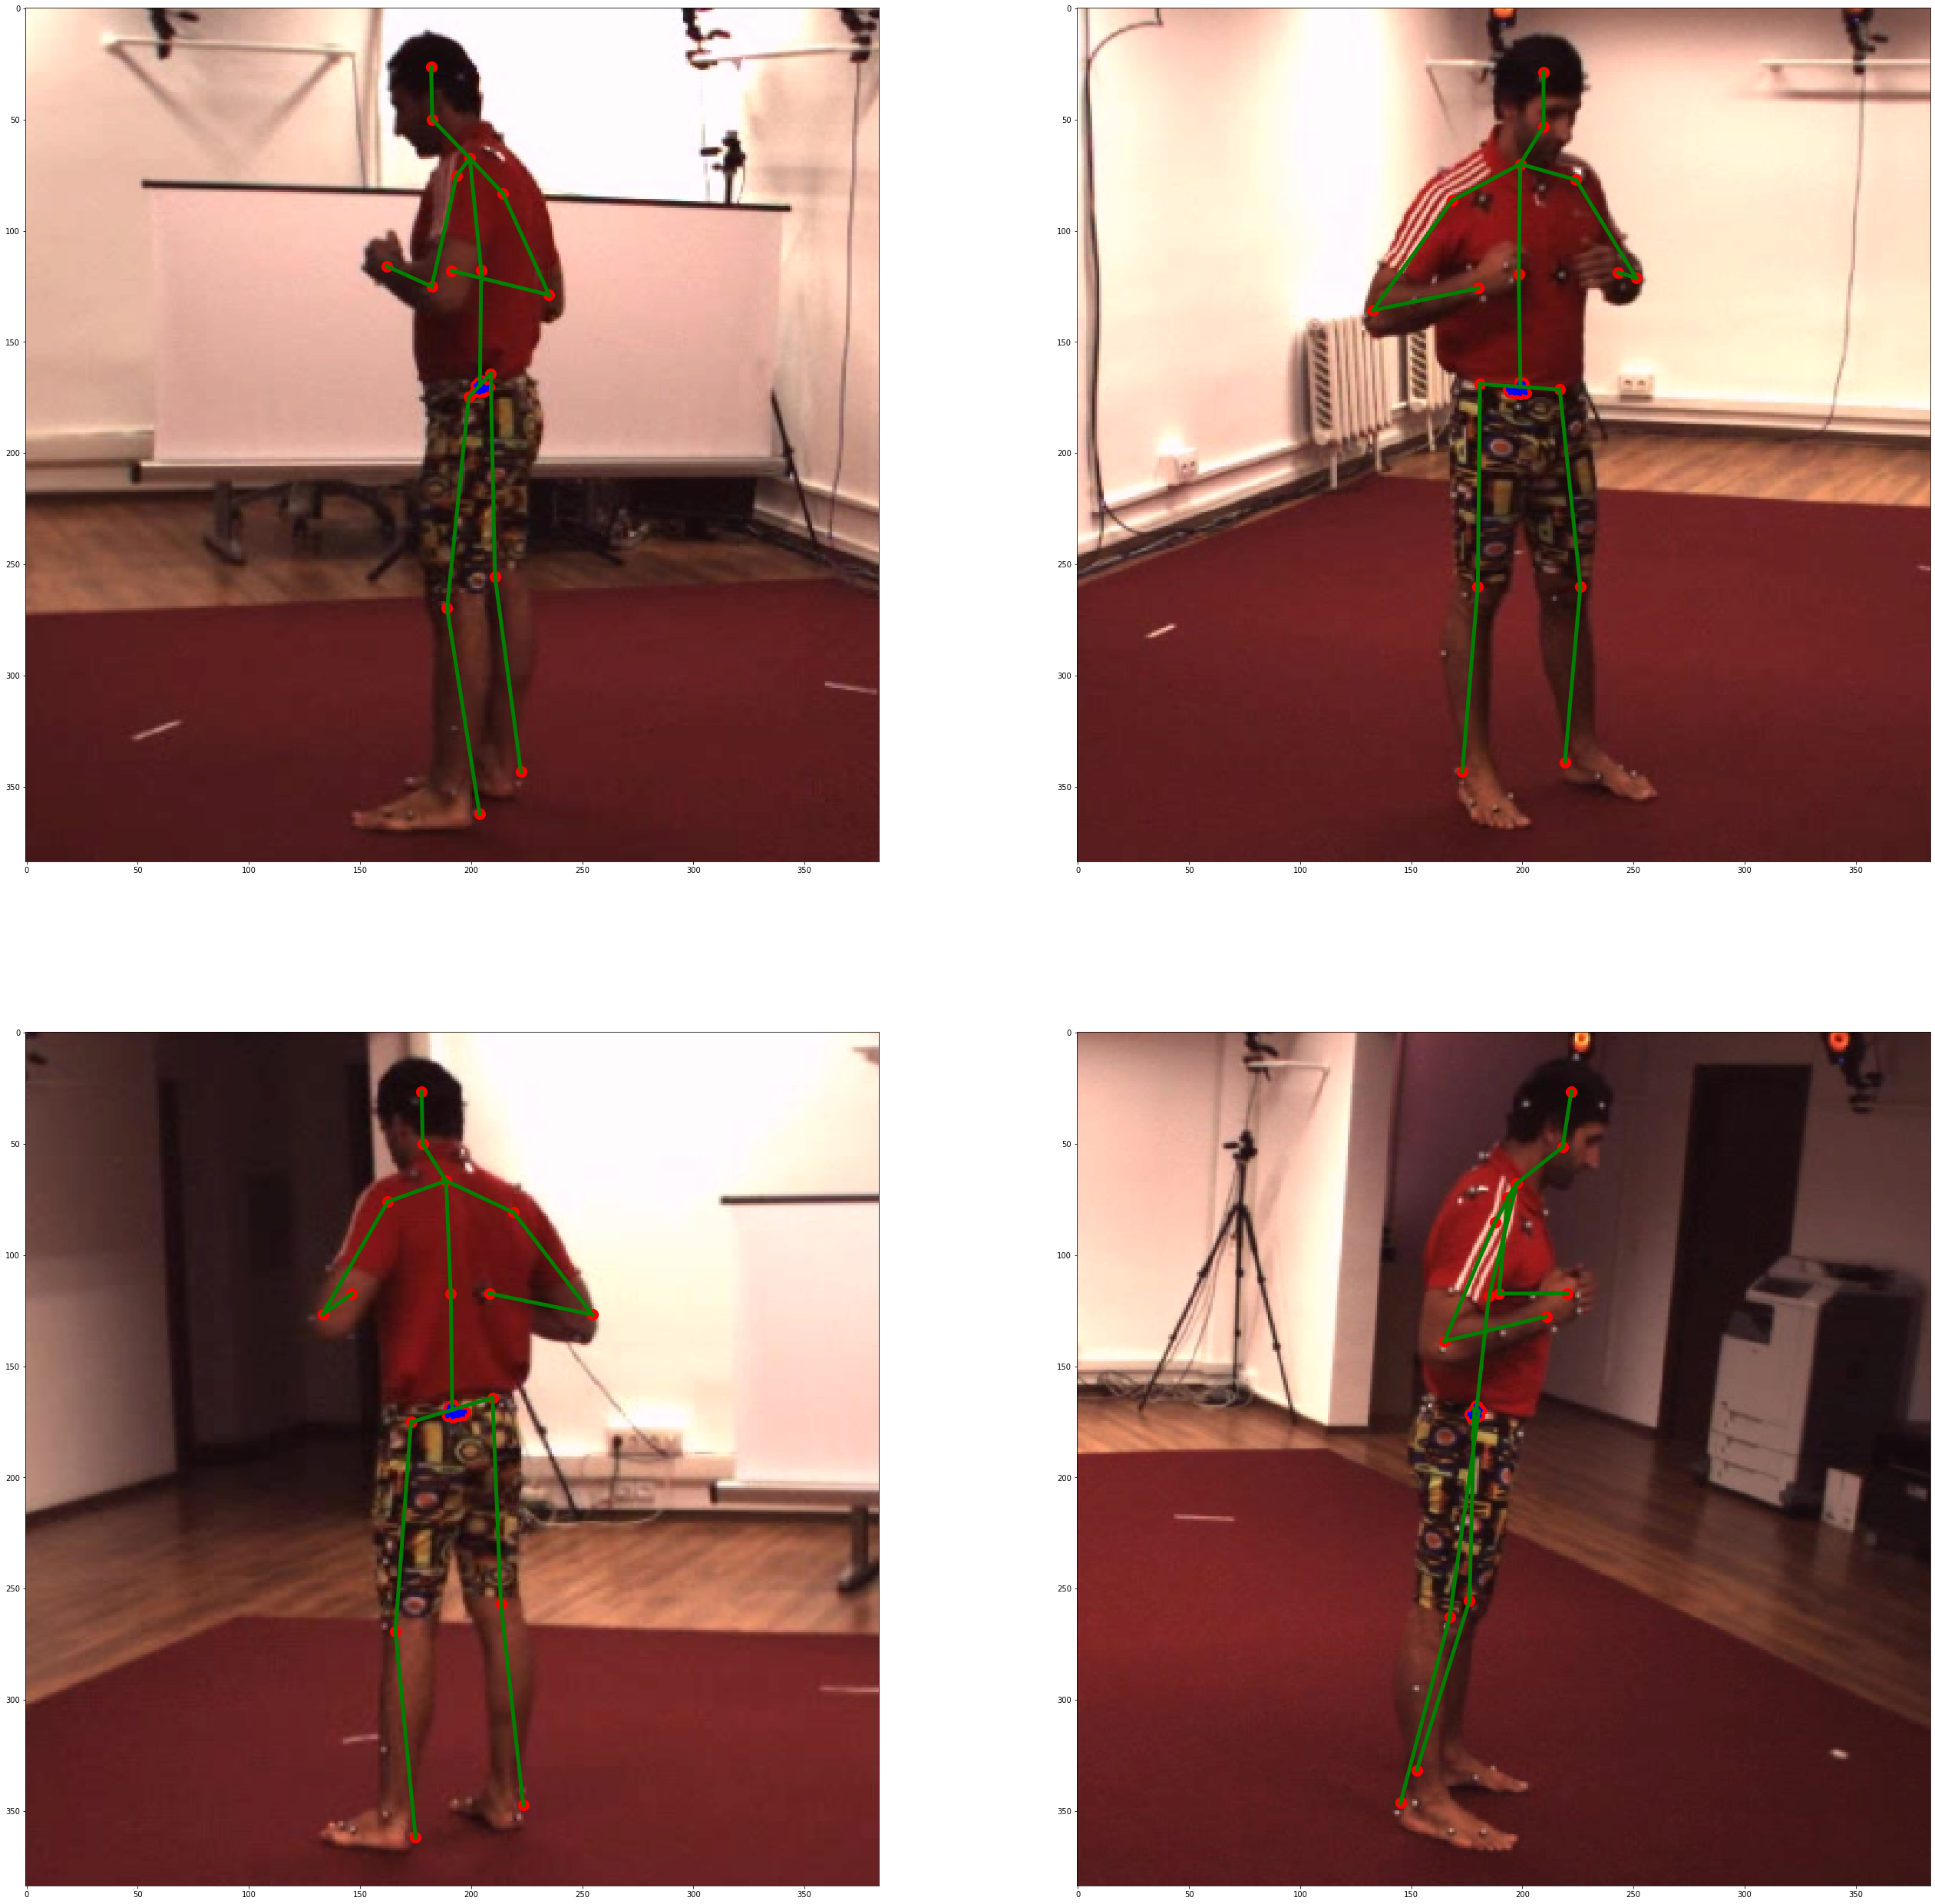

In [32]:
with_gt = True
with_random_style = True
add_per_joint_description = False

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
for view in range(4):
    
    # unpack
    image = series['images'][view][i]
    proj_matrice = series['proj_matrices'][view][i]
    keypoints_3d_gt = series['keypoints_gt'][i]
    keypoints_3d_pred = series['keypoints'][i] if not with_random_style else series['keypoints_random_style'][i]
    
    ax_i = ax.flatten()[view]
    ax_i.imshow(image)
    
    pjpe = np.linalg.norm(keypoints_3d_gt - keypoints_3d_pred, axis=-1)
    
    # predicted keypoints
    keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                                keypoints_3d_pred)
    draw_2d_pose(keypoints_2d_pred_proj,ax_i,kind='human36m', point_size=200, line_width=5)

    if with_gt:
        keypoints_2d_gt_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                                    keypoints_3d_gt)
        draw_2d_pose(keypoints_2d_gt_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')
        
    if view == eval_view and add_per_joint_description:
        ax_i.set_title('EVAL_VIEW', fontsize=34)
        text = ''.join([j_name + f': ~{int(pjpe[j_n])}' + '\n' for j_n,j_name in JOINT_H36_DICT.items()])
        h,w = image.shape[:2]
        offset_1, offset_2 = 5,10
        ax_i.text(0+offset_1, h-offset_2, text, style='italic', fontsize=25,
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.show()      

[autoreload of mvn.models.volumetric_lstm failed: Traceback (most recent call last):
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 434, in superreload
    module = reload(module)
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/media/hpc2_storage/ibulygin/miniconda3/envs/mvn/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source

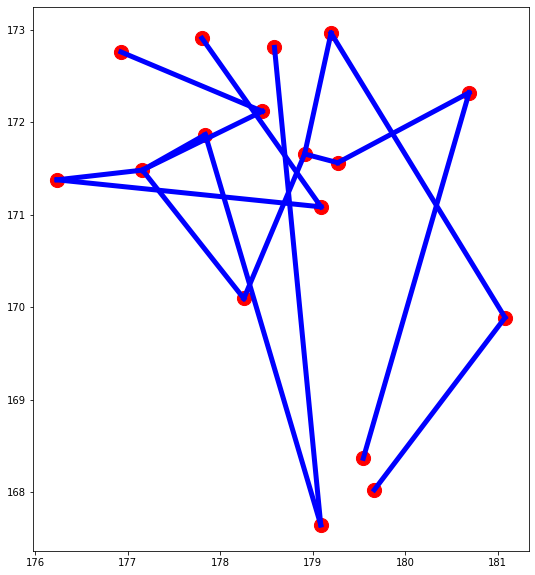

In [76]:
# predicted keypoints
plt.figure(figsize = (10,10))
ax = plt.subplot()
keypoints_2d_pred_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                            keypoints_3d_pred)
draw_2d_pose(keypoints_2d_pred_proj, ax, kind='human36m', point_size=200, line_width=5)

In [45]:
Y = series['keypoints_gt'].reshape(length, -1).copy()
X = series['keypoints_random_style'].reshape(length, -1).copy()

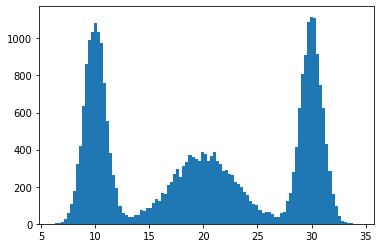

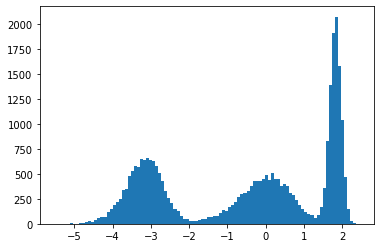

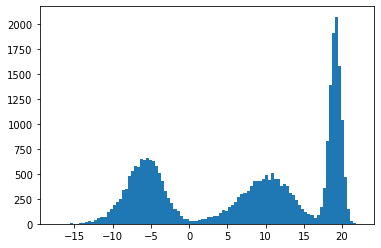

In [66]:
mu = np.array([10,20,30])
var = np.array([1,3,1])
dist = (np.random.randn(3,10000)*var[:,None] + mu[:,None]).flatten()

plt.figure()
plt.hist(dist, bins=100)
plt.show()

dist_norm = (dist - np.mean(dist))/np.sqrt(dist)
plt.figure()
plt.hist(dist_norm, bins=100)
plt.show()


dist_norm_ada = dist_norm*5 + 10
plt.figure()
plt.hist(dist_norm_ada, bins=100)
plt.show()


In [24]:
# with_gt, discr, smoothed = True, False, False
# os.system("ffmpeg -framerate 25 -i keypoints_videos_lowres/img_%05d.jpg -vcodec mpeg4 -y {6}/movie_{0}_{1}_{2}_f{3}_{4}_{5}.mp4".format(*index_to_name(start+length, stop_frame_indxs),
#                                                                                                                                                    '_with_gt' if with_gt else '',
#                                                                                                                                                    length,
#                                                                                                                                                     video_path))        

256

# Compare models video

In [13]:
video_path = os.path.join('videos/','baseline_vs_adain')
if not os.path.isdir(video_path):
    os.makedirs(video_path)
    print ('video_path - Created')
else:
    print ('video_path - Already exists')
    
keypoints_dir = os.path.join(video_path,'{0}_{1}'.format(subject, action),'keypoints_videos_lowres')
if not os.path.isdir(keypoints_dir):
    os.makedirs(keypoints_dir)
    print ('keypoints_dir - Created')
else:
    print ('keypoints_dir - Already exists')        

video_path - Created
keypoints_dir - Created


In [45]:
[1,2,3,4][2:]

[3, 4]

AssertionError: 

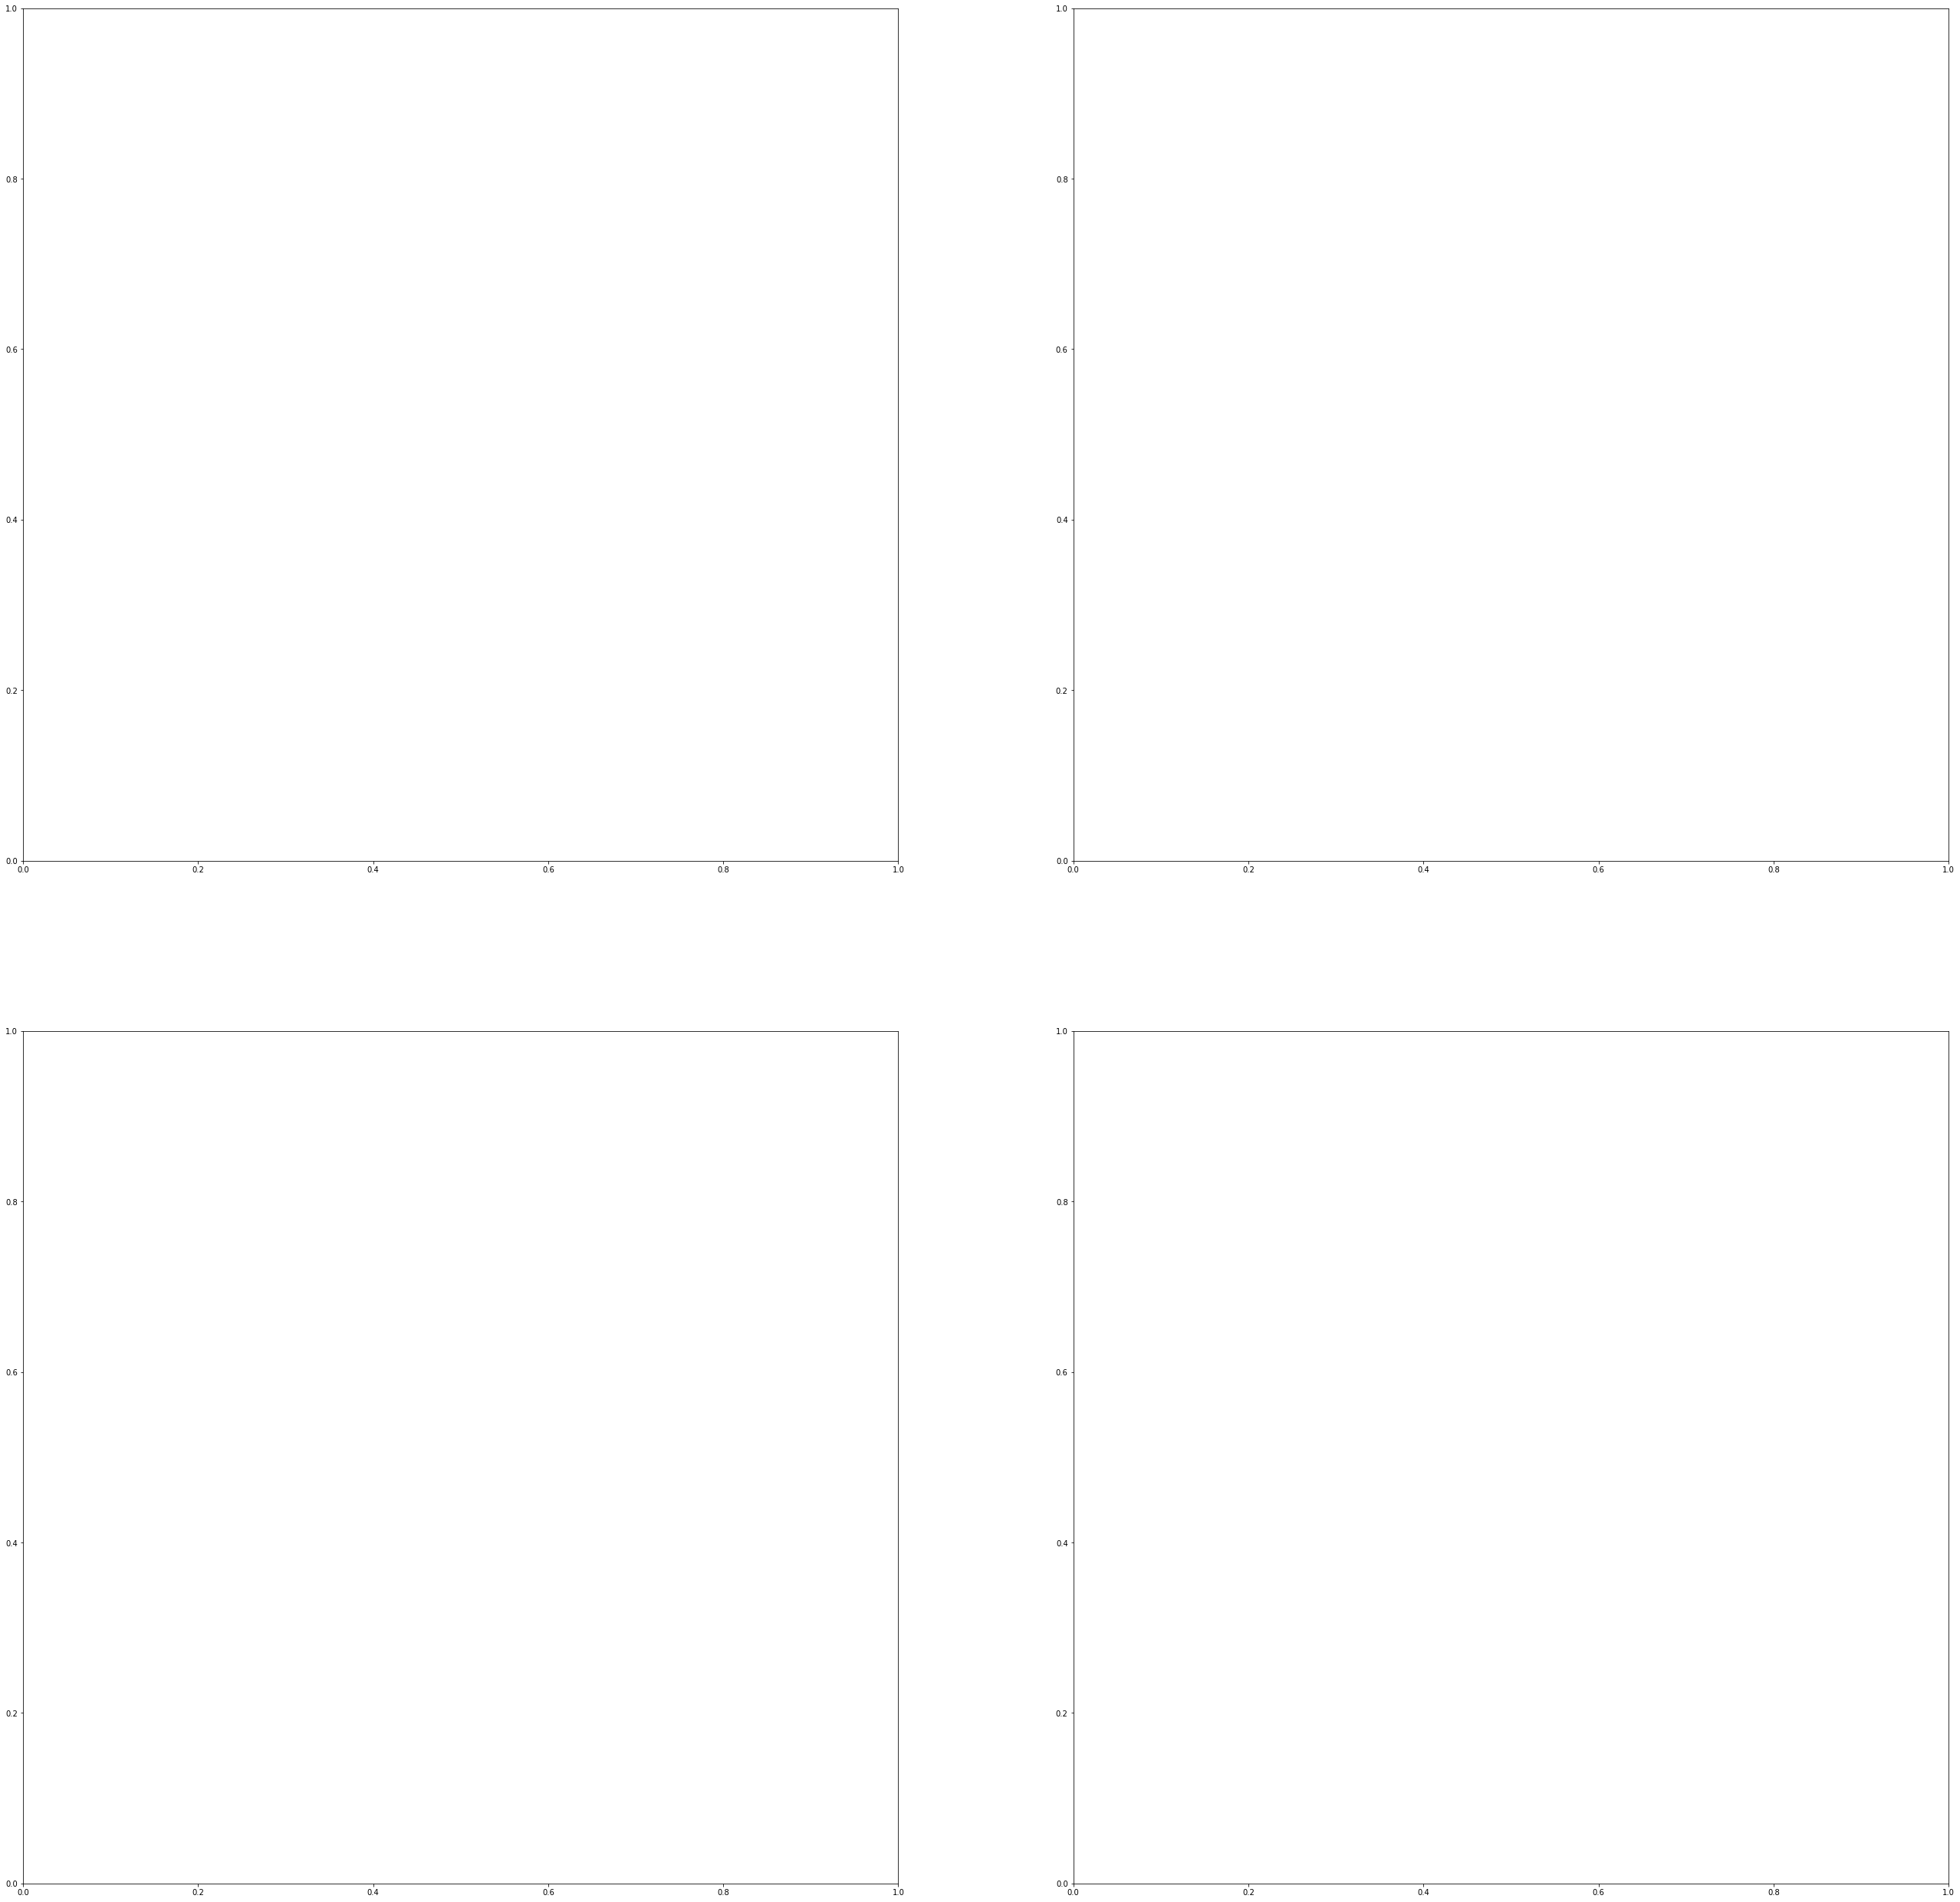

In [48]:
offset = 13
series_baseline = np.load('./action-Directions-1_subj-S9_l500-eval-0_model-vol.npy', allow_pickle=True).item()
series_model = np.load('./action-Directions-1_subj-S9_l500-eval-0_model-vol_temporal_adain.npy', allow_pickle=True).item()
add_per_joint_description = False

for i in tqdm_notebook(range(10)):

    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (45,45))
    for view in range(4):

        # unpack
        image = series_baseline['images'][view][offset:][i]
        proj_matrice = series_baseline['proj_matrices'][view][offset:][i]
        keypoints_3d_baseline = series_baseline['keypoints'][offset:][i]
        keypoints_3d_model = series_model['keypoints'][:-offset][i]
        
        keypoints_3d_gt_model = series_model['keypoints_gt'][:-offset][i]
        keypoints_3d_gt_baseline = series_baseline['keypoints_gt'][offset:][i]
        
        assert (keypoints_3d_gt_model == keypoints_3d_gt_baseline).all()
        
        
        ax_i = ax.flatten()[view]
        ax_i.imshow(image)

        pjpe_baseline = round(np.linalg.norm(keypoints_3d_gt - keypoints_3d_baseline, axis=-1).mean(),2)
        pjpe_model = round(np.linalg.norm(keypoints_3d_gt - keypoints_3d_model, axis=-1).mean(),2)
        
        # predicted keypoints
        keypoints_2d_baseline_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                                         keypoints_3d_baseline)
        draw_2d_pose(keypoints_2d_baseline_proj,ax_i,kind='human36m', point_size=200, line_width=5)

        keypoints_2d_model_proj = project_3d_points_to_image_plane_without_distortion(proj_matrice,
                                                                                    keypoints_3d_model)
        draw_2d_pose(keypoints_2d_model_proj, ax_i,kind='human36m', point_size=200, line_width=5, color='g')
    
        ax_i.set_title(f'MPJPE: model-{pjpe_model}, baseline-{pjpe_baseline}', fontsize=34)
            
    plt.savefig('./{}/img_{:05}.jpg'.format(keypoints_dir, i), bbox_inches='tight')
    plt.close()        


In [59]:
x1=series_model['keypoints_gt']
x2 =series_baseline['keypoints_gt']
abs(x2-x1[0]).sum(-1).sum(-1).max()

53604.438

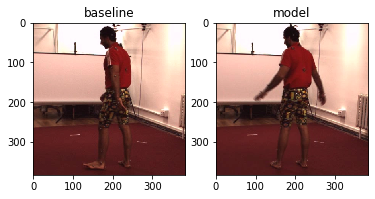

In [70]:
im1 = series_baseline['images'][0][2]
im2 = series_model['images'][0][0]
_, (ax1,ax2) = plt.subplots(ncols=2,nrows=1)
ax1.imshow(im1)
ax1.set_title('baseline')
ax2.imshow(im2)
ax2.set_title('model')
plt.show()